In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from tqdm import tqdm

import ipywidgets as widgets
from src.models import ContextSpaceNet

In [2]:
train_steps = 50000

nc = 5
n_in = 2 + nc # 2 position + 1 context
n_out = 100 # no. of spatial representations
bs = 128 # batch size

model = ContextSpaceNet(n_in, n_out, scale = 0.1, lam = 0.1)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

loss_history = []
progress = tqdm(range(train_steps))
for i in progress: # train loop
    r = torch.tensor(np.random.uniform(-1, 1, (bs, 2)), dtype= torch.float32)
    c = torch.tensor(np.random.uniform(-1, 1, (bs, nc)), dtype = torch.float32)
    inputs = torch.cat((r, c), dim = -1)
    labels = (r, c)

    loss = model.train_step(x = inputs, y = labels, optimizer = optimizer)

    if i % 10 == 0:
        loss_history.append(loss)
        progress.set_description(f"loss: {loss:>7f}")

loss: 0.003086: 100%|████████████████████████████████████████████████████████████████████| 50000/50000 [00:47<00:00, 1045.63it/s]


Text(0, 0.5, 'Train Loss')

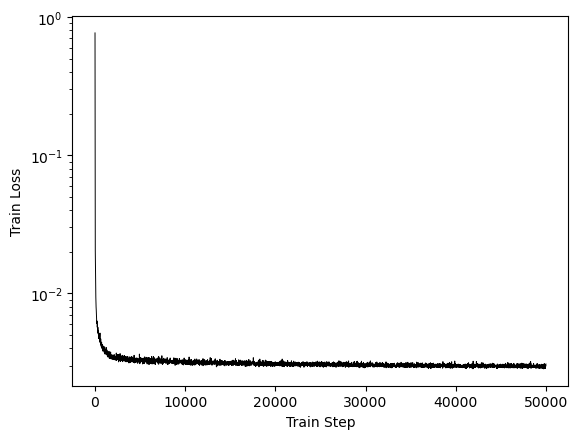

In [3]:
plt.semilogy(np.arange(0, train_steps, 10), loss_history, "-k", linewidth = 0.7)
plt.xlabel("Train Step")
plt.ylabel("Train Loss")

In [4]:
# evaluate on 2x2 grid
n = 32
x = np.linspace(-1, 1, n)
y = x.copy()
xx, yy = np.meshgrid(x,y)
u = torch.tensor(np.stack([xx.ravel(), yy.ravel()], axis = -1), dtype= torch.float32)

In [5]:
n_show = 5   # show ratemaps for first n_show nodes
cols = np.linspace(0,1, n_out)

def f(a, b):
    fig, ax = plt.subplots(n_show, n_show, figsize = (5, 5))
    context = torch.tensor(np.zeros((len(u), nc)), dtype = torch.float32)
    context[:,0] = a
    context[:,1] = b
    
    inputs = torch.cat((u, context), dim = -1)
    p = model.spatial_representation(inputs)
    p = p.detach().numpy()

    max_ind = np.argmax(p, axis = 0) 
    max_loc = u[max_ind]
    
    #spatial_correlation at center
    s_corr = np.exp(np.sum(-(p[512+16][None] - p)**2,axis=-1)).reshape(32,32)
    vmax = np.amax(p[:,:n_show**2])
    count = 0
    for i in range(n_show):
        for j in range(n_show):
            ax[i,j].imshow(p[:,count].reshape((n,n)), cmap = "jet", interpolation = "none")#, vmax = vmax)
            ax[i,j].axis("off")
            count += 1
    
    ax[-1,-1].imshow(s_corr, interpolation = "none")

    fig = plt.figure()
    mask = np.mean(p, axis = 0) > 0 # mask out active units
    plt.title(f"Non-zero units: {mask.sum()}")

    plt.scatter(*max_loc.T, c = cols, cmap = "jet")
    plt.axis([-2, 2, -2, 2])
    plt.axis("equal")
    
a_slider = widgets.FloatSlider(
    value=0,
    min=-1.0,
    max=1.0,
    step=0.01,
    description='a:',
    readout_format='.2f')

b_slider = widgets.FloatSlider(
    value=0,
    min=-1.0,
    max=1.0,
    step=0.01,
    description='b:',
    readout_format='.2f')


widgets.interactive(f, a = a_slider, b = b_slider)

interactive(children=(FloatSlider(value=0.0, description='a:', max=1.0, min=-1.0, step=0.01), FloatSlider(valu…